In [ ]:
#Basic Bybit API Inilisation
import pandas as pd
import numpy as np
from pybit import usdt_perpetual
from datetime import datetime
import calendar
import matplotlib.pyplot as plt

session_auth = usdt_perpetual.HTTP(endpoint='https://api.bybit.com', api_key='HNSBQYMATFZDGZEZHK', api_secret='PBKHRDKTETGRLJQQYZILYBTIEZXWRNNEHMUP')

now = datetime.utcnow()
unixtime = calendar.timegm(now.utctimetuple())
since = unixtime #time elapsed Jan 1st 1970 in seconds
start=str(since-(1*86400))
Days_5_back = str(since-(3600*200)) #86400 seconds in a day (2 means yesterday and today etc) (1st number is number of seconds, 2nd is number of data points)

response = (session_auth.query_kline(symbol="BTCUSDT", interval="60",from_time=Days_5_back))['result'] # the current candle is given as the last data point
git = pd.DataFrame(response)
adx_only = git.copy()

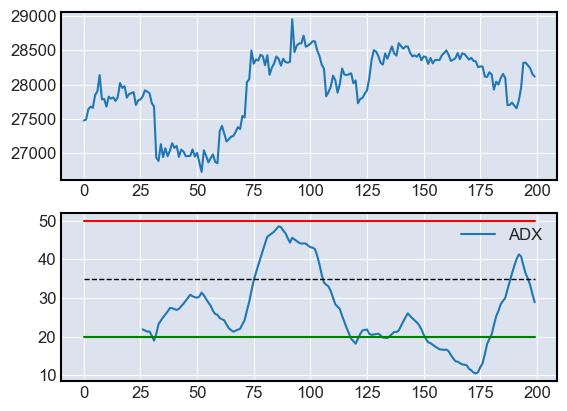

In [7]:
#From Github ADX
interval  = 14 #look back period

git['-DM'] = git['low'].shift(1) - git['low']
git['+DM'] = git['high'] - git['high'].shift(1)
git['+DM'] = np.where((git['+DM'] > git['-DM']) & (git['+DM']>0), git['+DM'], 0.0)
git['-DM'] = np.where((git['-DM'] > git['+DM']) & (git['-DM']>0), git['-DM'], 0.0)
git['TR_TMP1'] = git['high'] - git['low']
git['TR_TMP2'] = np.abs(git['high'] - git['close'].shift(1))
git['TR_TMP3'] = np.abs(git['low'] - git['close'].shift(1))  
git['TR'] = git[['TR_TMP1', 'TR_TMP2', 'TR_TMP3']].max(axis=1)

for i in range(interval-1 , len(git['close'])):
    if(i == interval - 1):
        git.loc[i,'TR_smt'] = git.loc[0:interval, 'TR'].mean()
        git.loc[i,'+DM_smt'] = git.loc[0:interval, '+DM'].mean()
        git.loc[i,'-DM_smt'] = git.loc[0:interval, '-DM'].mean()
    else:
        git.loc[i,'TR_smt'] = ( (git.loc[i-1,'TR_smt'] * (13)) + git.loc[i,'TR'] )/14
        git.loc[i,'+DM_smt'] = ( (git.loc[i-1,'+DM_smt'] * (13)) + git.loc[i,'+DM'] )/14
        git.loc[i,'-DM_smt'] = ( (git.loc[i-1,'-DM_smt'] * (13)) + git.loc[i,'-DM'] )/14


git['+DI'] = ( git['+DM_smt'] / git['TR_smt'] )*100
git['-DI'] = ( git['-DM_smt'] / git['TR_smt'] )*100

git['DX'] = ( abs(git['+DI'] - git['-DI']) / abs(git['+DI'] + git['-DI']) )*100

for i in range(2*(interval-1) , len(git['close'])):
    if(i == 2*(interval - 1)):
        git.loc[i,'ADX'] = git.loc[(interval - 1) : 2*(interval - 1), 'DX'].mean()
    else:
        git.loc[i,'ADX'] = ( (git.loc[i-1,'ADX'] * 13) + git.loc[i,'DX'] )/14

adx_only['ADX'] = git['ADX']

fig , axis = plt.subplots(2,1)
axis[0].plot(git['close'], linewidth="1.5")
axis[1].plot(git['ADX'] , label = 'ADX', linewidth="1.5")
#axis[1].plot(git['+DI'] , label = '+DI')
#axis[1].plot(git['-DI'] , label = '-DI')

min_valuex = [0,199]
min_valuey = [20,20]
plt.plot(min_valuex,min_valuey, color="green", linewidth="1.5")

max_valuex = [0,199]
max_valuey = [50,50]
plt.plot(max_valuex,max_valuey, color="red", linewidth="1.5")

mid_valuex = [0,199]
mid_valuey = [35,35]
plt.plot(mid_valuex,mid_valuey, linestyle="--", linewidth="1", color="black")

plt.legend()
plt.show()


In [2]:
#Makes chart look better
import mplfinance as mpf

data = git[['open_time', 'open', 'high', 'low', 'close', 'volume']]
data['Date'] = pd.to_datetime(data['open_time'])
data.set_index('Date', inplace=True)
mpf.plot(data, type='candle', volume=False)
plt.show()

NameError: name 'git' is not defined